In [20]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd
import json

def get_column_names(benchmark): 
    table_info = json.load(open(benchmark + '_results.csv.json','r'))
    #print(json.dumps(table_info, indent=2, sort_keys=False))
    column_names = []
    for column in table_info["columns"]:
        column_names.append(column["name"])
    return column_names

def get_results(benchmark):
    return pd.read_csv(benchmark + '_results.csv', header=None, names=get_column_names(benchmark))

# Columns: sample_size, distinct_values, variance, remainder_size, value, actual_count, filter_count

def select(data, value_count, distinct_values, variance, quotient_size, remainder_size):
    return data[(data.value_count == value_count) &
                (data.distinct_values == distinct_values) &
                (data.variance == variance) & 
                (data.remainder_size == remainder_size) &
                (data.quotient_size == quotient_size)]

def misestimation_evaluation(quotient_size, remainder_size):
    value_count = 100000
    distinct_values = 3000
    variance = 500.0
    sample_size = 300000

    data = get_results("cardinality_misestimation")
    selection = select(data, value_count, distinct_values, variance, quotient_size, remainder_size)
    selection[["over_estimation", "occurrences"]].head()
    title = "Misestimation probabilites"
    subtitle = "Value Count: " + str(value_count) \
                + ", Distinct Values: " + str(distinct_values) \
                + ", Variance: " + str(variance) + '\n' \
                + "Quotient Size: " + str(quotient_size) + ", Remainder Size: " + str(remainder_size)
            
    plt.title(title + '\n' + subtitle)
    plt.plot(selection["over_estimation"][1:100], selection["occurrences"][1:100], color="red", label="filter counts")
    #plt.legend(loc='upper left')
    plt.ylabel('probability')
    plt.xlabel('misestimation')
    
    #file_name = (title + '_' + subtitle).replace(" ", "_").replace(":", "_").replace(".","_").replace(",","_").replace("\n","_")
    #plt.savefig('plots/cardinality_estimation/{}.pgf'.format(file_name))
    #plt.savefig('plots/cardinality_estimation/{}.pdf'.format(file_name))
    plt.show()

def evaluate(quotient_size, remainder_size):
    value_count = 100000
    distinct_values = 3000
    variance = 500.0

    data = get_results("filter_cardinality_estimation")
    selection = select(data, value_count, distinct_values, variance, quotient_size, remainder_size)
    selection[["value", "actual_count", "filter_count"]].head()
    title = "Filter Counts Vs. Actual Counts"
    subtitle = "Value Count: " + str(value_count) \
                + ", Distinct Values: " + str(distinct_values) \
                + ", Variance: " + str(variance) + '\n' \
                + "Quotient Size: " + str(quotient_size) + ", Remainder Size: " + str(remainder_size)
            
    plt.title(title + '\n' + subtitle)
    plt.plot(selection["value"], selection["filter_count"], color="red", label="filter counts")
    plt.plot(selection["value"], selection["actual_count"], color="blue", label="actual counts")
    plt.legend(loc='upper left')
    plt.ylabel('value count')
    plt.xlabel('value')
    
    file_name = (title + '_' + subtitle).replace(" ", "_").replace(":", "_").replace(".","_").replace(",","_").replace("\n","_")
    plt.savefig('plots/cardinality_estimation/{}.pgf'.format(file_name))
    plt.savefig('plots/cardinality_estimation/{}.pdf'.format(file_name))
    plt.show()

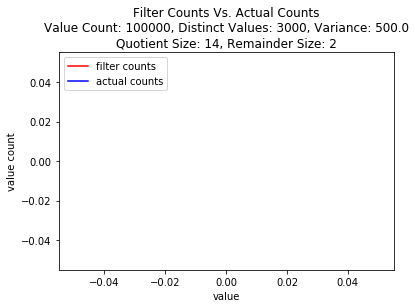

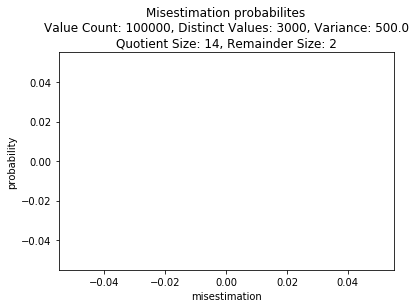

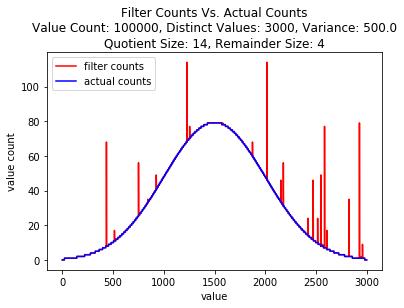

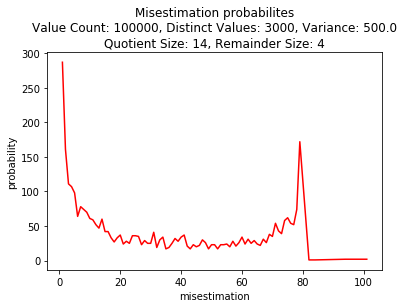

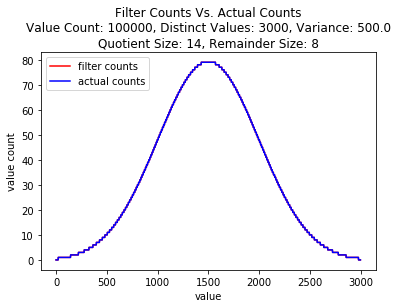

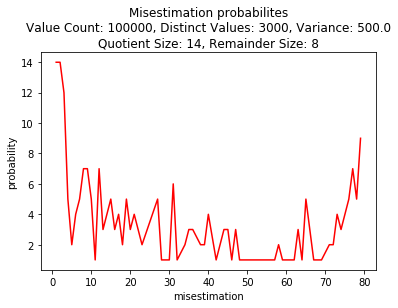

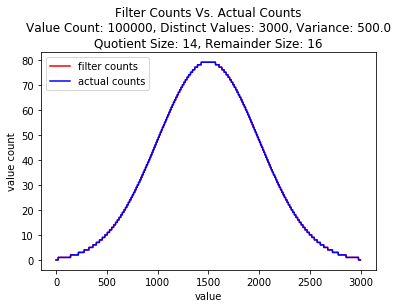

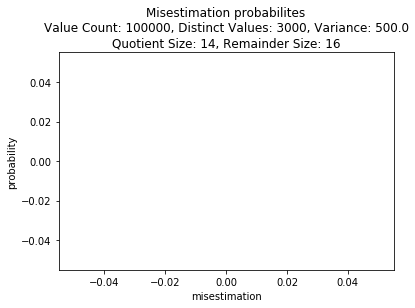

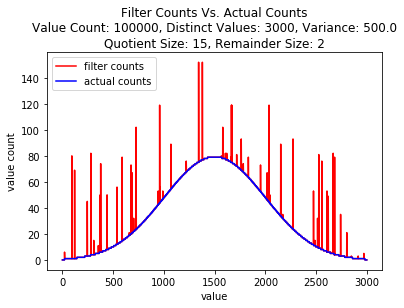

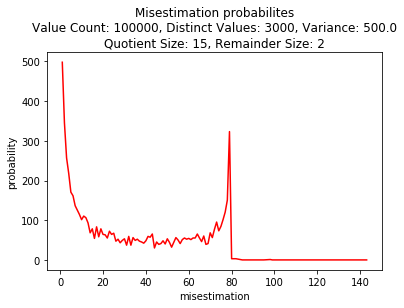

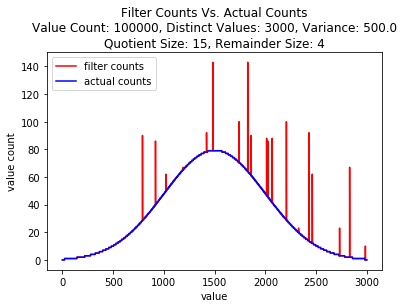

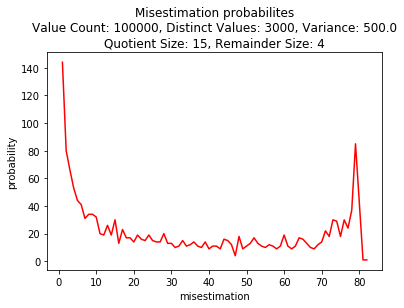

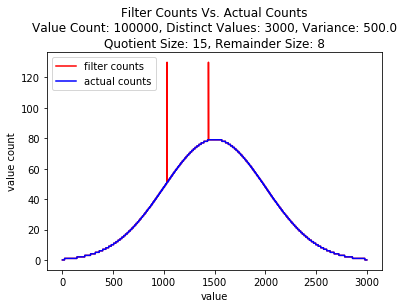

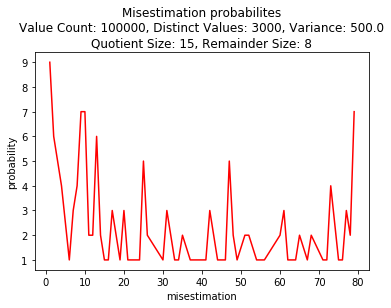

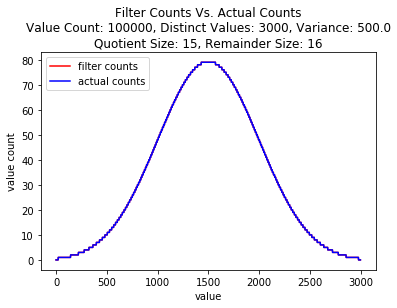

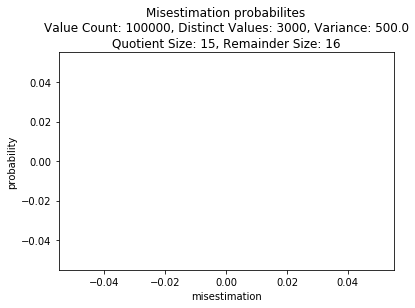

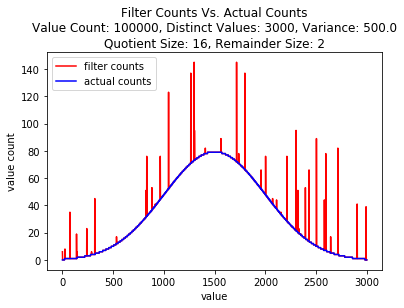

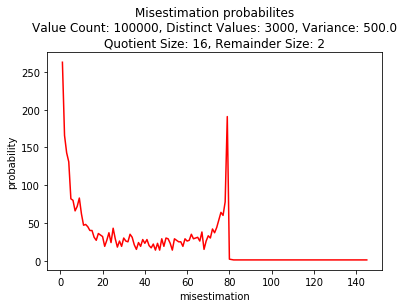

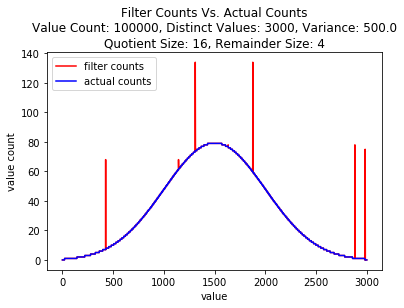

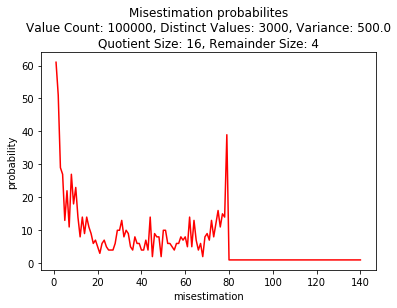

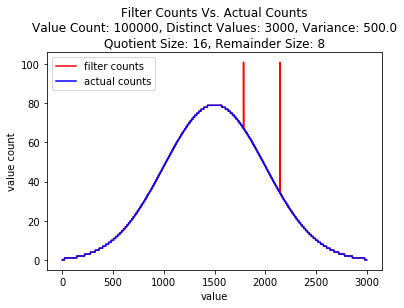

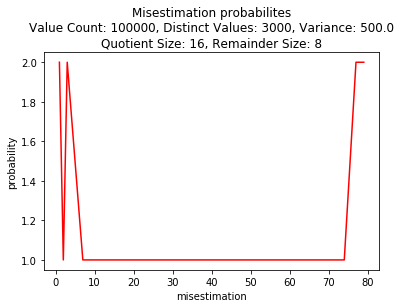

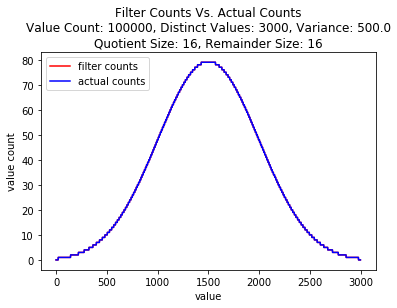

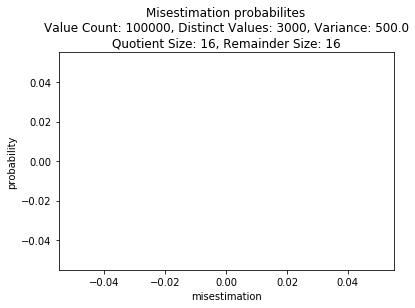

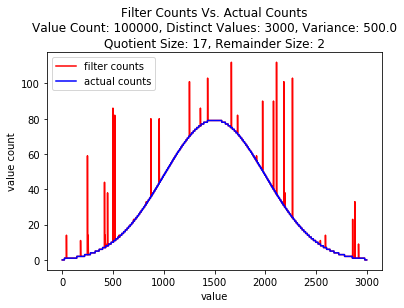

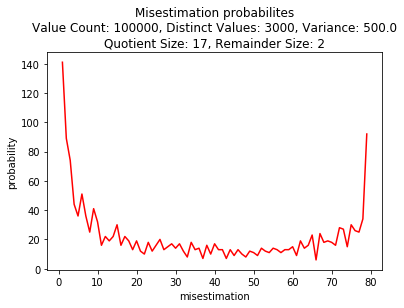

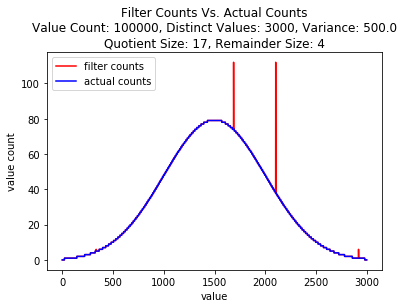

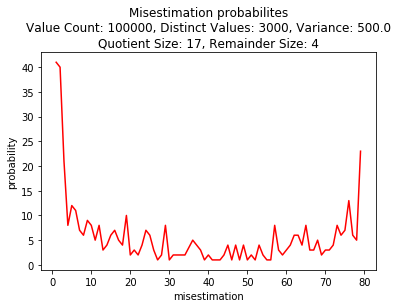

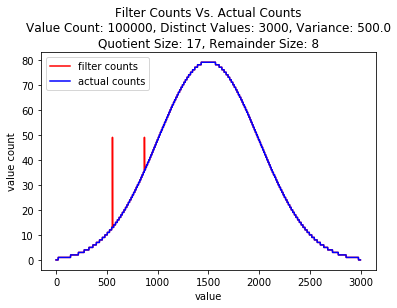

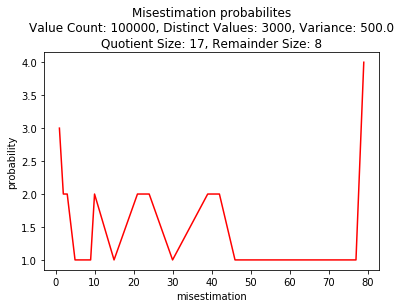

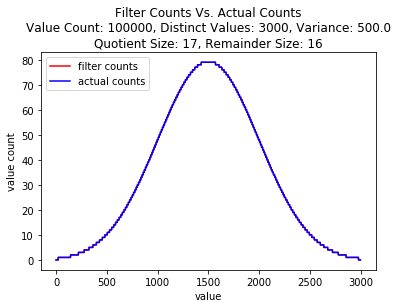

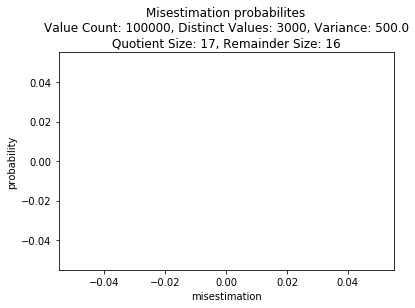

In [21]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [14, 15, 16, 17]

for quotient_size in quotient_sizes:
    for remainder_size in remainder_sizes:
        evaluate(quotient_size, remainder_size)
        misestimation_evaluation(quotient_size, remainder_size)